## ANN

This class contains our simple artificial neural network (ANN) instance. It has the following customizable parameters

Initialization:
- `rand_mean` - mean of the normal distribution used to initialize W and B
- `rand_std` - STD of the normal distribution used to initialize W and B

Training/Learning:
- `learn_rate` - learn rate as a double between 0 and 1
- `batch_size` - size of each data pushed through forward propagation. 
- `num_epoch` - number of data set passes through the ANN.
- `w_shapes` - shape of each weight matrix W, like (out_dim, in_dim), written from left to right. `w_shapes[i - 1][0] == w_shapes[i][1]`
- `b_shapes` - shape of each bias vector B with the same count as `w_shapes`. always a column vector such that `w_shapes[i][0] == b_shapes[i][0]`
- `activ_funcs` - activation functions for each layer with the same count as `w_shapes`. each function always accepts only one parameter
- `activ_funcs_dx` - equivalent derivative functions of the activation functions in `activ_funcs`. each function always accepts only one parameter

In [5]:
import numpy as np
from matplotlib import pyplot as plt
import time

In [53]:
class ANN():
    def __init__(self): 
        self.rand_mean = 0
        self.rand_std = 0.01

        self.learn_rate = 0.1
        self.batch_size = 1
        self.num_epoch = 20

        self.w_shapes = [(64, self.batch_size), (64, 64), (self.batch_size, 64)]
        #self.b_shapes = [(64, 1), (64, 1), (self.batch_size, 1)]
        self.activ_funcs = [self.relu, self.relu, self.sigmoid]
        self.activ_funcs_dx = [self.relu_dx, self.relu_dx, self.sigmoid_dx]

        self.wx = [np.random.normal(self.rand_mean, self.rand_std, x) for x in self.w_shapes]
        #self.bx = [np.random.normal(self.rand_mean, self.rand_std, x) for x in self.b_shapes]

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_dx(self, x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))

    def relu(self, x):
        return np.maximum(0, x)

    def relu_dx(self, x):
        # NOTE: No derivative at x = 0
        # Convention is dx at 0 is zero
        relu_scalar = lambda x: 1 if x > 0 else 0
        relu_vec = np.vectorize(relu_scalar)

        return relu_vec(x)
    
    def save_data(self, data, filename="hw02_data.txt"):
        np.savetxt(filename, data, fmt="%s")
    
    def init_params(self):
        self.wx = [np.random.normal(self.rand_mean, self.rand_std, x) for x in self.w_shapes]
        #self.bx = [np.random.normal(self.rand_mean, self.rand_std, x) for x in self.b_shapes]
    
    def forward_prop(self, in_data):
        ax = [[] for i in range(len(self.wx))]
        zx = [[] for i in range(len(self.wx))]
        
        for i in range(len(self.wx)):
            past_val = in_data if i == 0 else ax[i - 1]
        
            zx[i] = self.wx[i].dot(past_val)
            ax[i] = self.activ_funcs[i](zx[i])
        
        return zx, ax
    
    def backward_prop(self, zx, ax, in_data, answer_data):
        '''
        dWx = [[] for i in range(len(self.w_shapes))]

        error = -2 * (out_actual - ax[2]) * self.sigmoid_dx(zx[2])
        dWx[2] = error.dot(ax[1].T)

        error = self.wx[2].T.dot(error) * self.relu_dx(zx[1])
        dWx[1] = error.dot(ax[0].T)

        error = self.wx[1].T.dot(error) * self.relu_dx(zx[0])
        dWx[0] = error.dot(in_data.T)

        for i, v in enumerate(dWx):
            self.wx[i] -= self.learn_rate * v
        '''
        
        dWx = [[] for i in range(len(self.w_shapes))]
        error = 0
        
        pred_data = ax[-1]
        
        # Determine change
        for i in reversed(range(len(self.wx))):
            past_cost = (-2 * (answer_data - pred_data) / ax[-1].shape[0]) if i == len(self.wx) - 1 else self.wx[i + 1].T.dot(error)
            activ_dx = self.activ_funcs_dx[i](zx[i])
            f_val = in_data if i == 0 else ax[i - 1]
            
            error = past_cost * activ_dx
            dWx[i] = error.dot(f_val.T)
        
        # Recalibrate weights
        for i in range(len(self.wx)):
            self.wx[i] -= self.learn_rate * dWx[i]
        
        return self.wx
    
    def predict(self, data_in):
        num_iters = int(len(data_in) / self.batch_size)
        out_pred_vec = []
        
        for each_batch_idx in range(num_iters):
            batch_start_idx = self.batch_size * each_batch_idx
            
            in_data = np.atleast_2d(data_in[batch_start_idx:batch_start_idx + self.batch_size]).T
            
            _, new_ax = self.forward_prop(in_data)
            out_pred = new_ax[-1]
            out_pred_vec.append(out_pred)
        
        return out_pred_vec
    
    def train(self, data_in, data_out, clear_params=False):
        start_time = time.time()
        
        if clear_params:
            self.init_params()
            
        # Training workflow
        num_iters = int(len(data_in) / self.batch_size)
        print(f'Running training for {self.num_epoch} epoch(s), {self.batch_size} batch(es), and {num_iters} iteration(s)')

        for each_epoch_idx in range(self.num_epoch):
            mse_vec = []
            
            # Randomize data each epoch
            #rand_idxs = np.random.permutation(data_in.size)
            #data_in = data_in[rand_idxs]
            #data_out = data_out[rand_idxs]
            
            for each_batch_idx in range(num_iters):
                batch_start_idx = self.batch_size * each_batch_idx

                in_data = np.atleast_2d(data_in[batch_start_idx:batch_start_idx + self.batch_size]).T
                out_actual = np.atleast_2d(data_out[batch_start_idx:batch_start_idx + self.batch_size]).T

                # Forward
                zx, ax = self.forward_prop(in_data)

                # Back - MSE as loss function
                self.backward_prop(zx, ax, in_data, out_actual)
                
                mse_vec.append(ax[2] - out_actual)
                
                if (each_batch_idx % (num_iters / 10)) == 0:
                    print(f'At idx: {in_data} -> {out_actual}T vs {ax[-1]}P')
            
                #print(in_data, out_actual, ax[2])
            
            mse_val = np.sum(np.square(mse_vec)) / len(data_in)
            
            print(f'Epoch {each_epoch_idx + 1} MSE: {mse_val}')
            print(f'Min Weight Vals: {np.min(self.wx[0]), np.min(self.wx[1]), np.min(self.wx[2])}')
            print(f'Max Weight Vals: {np.max(self.wx[0]), np.max(self.wx[1]), np.max(self.wx[2])}')
            
            #self.save_data(self.wx[0], filename=f"wx0_{each_epoch_idx}.txt")
            #self.save_data(self.wx[1], filename=f"wx1_{each_epoch_idx}.txt")
            #self.save_data(self.wx[2], filename=f"wx2_{each_epoch_idx}.txt")
        
        print(f'Training done in {round(time.time() - start_time, 2)}s!')

    def test(self, data_in, data_out):
        start_time = time.time()
        
        # Test workflow
        num_iters = int(len(data_in) / self.batch_size)
        mse_vec = []
        
        out_pred = np.reshape(self.predict(data_in), data_in.shape)
        mse_vec = data_out - out_pred
        
        mse_val = np.sum(np.square(mse_vec)) / len(data_in)
        
        print(f'Min Weight Vals: {np.min(self.wx[0]), np.min(self.wx[1]), np.min(self.wx[2])}')
        print(f'Max Weight Vals: {np.max(self.wx[0]), np.max(self.wx[1]), np.max(self.wx[2])}')
        print(f'Mean squared error: {mse_val}')
        
        print(f'Test done in {round(time.time() - start_time, 2)}s!')
        
        return out_pred
    
    def plot_test(self, data_in, data_out):
        y_pred = self.test(data_in, data_out)
        
        plt.figure()
        plt.scatter(data_in, data_out, s=2)
        plt.scatter(data_in, y_pred, s=6, c='r')
        plt.xlabel('Sample Value')
        plt.ylabel('Chance')

## Init
The following contains the routine to set-up the normal distribution data. It has the following customizable parameters.

- `mean` - mean of the normal distribution where the input data will be sampled
- `std` - STD of the normal distribution where the input data will be sampled
- `num_samp` - number of samples to get from the normal distribution
- `num_bins` - granularity of the output. the bins 
- `train_percent` - percent of the data that will be allocated as the training dataset. between 0 and 1

The data sampling works by first getting `num_samp` samples from a normal distribution with mean `mean` and std `std`. Then, a histogram of the samples were generated - which are then sorted into `num_bins` bins. The histogram approximates a normal distribution, with each bin holding the value of the approximate probability density function (pdf) of the distribution such that the overall area is 1. The sample data are then labeled to determine which bin they belong. Then, they are shuffled once to ensure a randomized dataset split. The sample data is then split into training and test datasets from this shuffling.

The input is the sample data at the distribution and the output is its pdf at that value.

In [54]:
# Set initial inputs here
mean = 5
std = 1
num_samp = 1000000
num_bins = 1000
train_percent = 0.9

# Draw 1m samples from a 1D normal distribution with the given mean and std
# From a sample, predict its chance [0, 1]
norm_samp = np.random.normal(mean, std, (1, num_samp))
norm_hist_out, norm_edges = np.histogram(norm_samp, bins=num_bins, density=True)
norm_hist_idxs = np.digitize(norm_samp, norm_edges)

# Pre-filter histogram idxs
norm_hist_idxs -= 1
norm_hist_idxs[norm_hist_idxs <= 0] = 0
norm_hist_idxs[norm_hist_idxs >= norm_hist_out.size] = norm_hist_out.size - 1

# Split dataset by shuffling the bins
train_bound_idx = int(train_percent * norm_samp.size)
rand_idxs = np.random.permutation(norm_samp.size) 
train_idxs, test_idxs = rand_idxs[:train_bound_idx], rand_idxs[train_bound_idx:]

train_set_in, train_set_out = norm_samp[0][train_idxs], norm_hist_out[norm_hist_idxs[0][train_idxs]]
test_set_in, test_set_out = norm_samp[0][test_idxs], norm_hist_out[norm_hist_idxs[0][test_idxs]]

print(f'Mean: {mean}; STD: {std}')
print(f'TotalData: {len(rand_idxs)}; NumTrain: {len(train_set_in)}; NumTest: {len(test_set_in)}')

Mean: 5; STD: 1
TotalData: 1000; NumTrain: 900; NumTest: 100


## Training
The following snippet trains a freshly-initialized ANN. The program prints every other batch since the training itself can get pretty long.

In [55]:
# Create ANN
ann_model = ANN()
ann_model.train(train_set_in, train_set_out, clear_params=True)

Running training for 3 epoch(s), 1 batch(es), and 900 iteration(s)
At idx: [[6.37223739]] -> [[0.33775799]]T vs [[0.49992501]]P
At idx: [[4.88750426]] -> [[0.33775799]]T vs [[0.49991731]]P
At idx: [[5.73828744]] -> [[0.33775799]]T vs [[0.49986829]]P
At idx: [[4.17618157]] -> [[0.84439498]]T vs [[0.49987873]]P
At idx: [[5.10429331]] -> [[0.67551599]]T vs [[0.4998309]]P
At idx: [[4.05661794]] -> [[0.50663699]]T vs [[0.49978933]]P
At idx: [[3.88933506]] -> [[0.50663699]]T vs [[0.49972195]]P
At idx: [[4.82082767]] -> [[0.33775799]]T vs [[0.49963248]]P
At idx: [[4.3328766]] -> [[0.33775799]]T vs [[0.49965985]]P
At idx: [[4.95772573]] -> [[0.84439498]]T vs [[0.4994983]]P
Epoch 1 MSE: 0.05817015458259337
Min Weight Vals: (-0.02353612347756324, -0.03940214243464389, -0.030089965136066182)
Max Weight Vals: (0.03102791577766622, 0.039825005303173684, 0.03200058875980276)
At idx: [[6.37223739]] -> [[0.33775799]]T vs [[0.49917377]]P
At idx: [[4.88750426]] -> [[0.33775799]]T vs [[0.49914572]]P
At i

## Test
The following snippet tests the ANN trained previously. It also outputs a plot of the original and predicted data.

Min Weight Vals: (-0.024497876383488288, -0.03547003771274309, -0.14832547521903297)
Max Weight Vals: (0.12696981418517392, 0.058081556884464466, 0.022122488807400947)
Mean squared error: 0.06957187465895928
Test done in 0.0s!


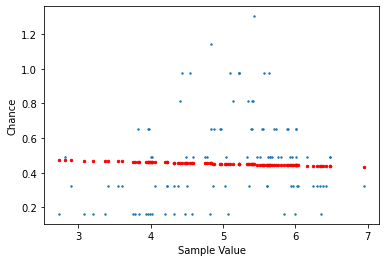

In [46]:
# Test workflow
# Use a simple validation set for cross-validation
#ann_model.test(test_set_in, test_set_out)
ann_model.plot_test(test_set_in, test_set_out)